In [47]:
# Hyperparameters:
batch_size = 128
learning_rate = 0.001
epochs = 120

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torchvision.models as models
import kagglehub
import os
import pandas as pd
import numpy as np
from datetime import timedelta
import math
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error

In [49]:
# Get training and validation sets
train_set = torch.load("./Datasets/train_set.pt", weights_only=False)
val_set = torch.load("./Datasets/val_set.pt", weights_only=False)

def preprocess_tensor(tensor):
    return torch.nan_to_num(tensor, nan=0.0)  # Replace NaN with 0.0

# Preprocess train and validation datasets
train_set = [(preprocess_tensor(x), y) for x, y in train_set]
val_set = [(preprocess_tensor(x), y) for x, y in val_set]

# Convert datasets into tensor datasets
train_data = TensorDataset(
    torch.stack([x for x, y in train_set]),
    torch.tensor([y.item() for x, y in train_set]).float()
)
val_data = TensorDataset(
    torch.stack([x for x, y in val_set]),
    torch.tensor([y.item() for x, y in val_set]).float()
)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [50]:
# Define Linear Regression Model
class SimpleLinearRegression(nn.Module):
    def __init__(self, input_size):
        super(SimpleLinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)  # One output node for regression

    def forward(self, x):
        return self.linear(x)

In [51]:
# Initialize the model
input_size = train_set[0][0].shape[0]
model = SimpleLinearRegression(input_size)

In [52]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # Learning rate of 0.01

In [53]:
# Lists to store losses for plotting
train_losses = []
val_losses = []

# Train the model
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0

    # Training loop
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on validation set
    model.eval()
    mse = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            mse += loss.item()

    avg_val_loss = mse / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}]: Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

Epoch [1/120]: Training Loss: 10725.1566, Validation Loss: 7757.0365
Epoch [2/120]: Training Loss: 7161.4662, Validation Loss: 6506.0316
Epoch [3/120]: Training Loss: 6118.8798, Validation Loss: 6223.0618
Epoch [4/120]: Training Loss: 5948.8597, Validation Loss: 5986.3932
Epoch [5/120]: Training Loss: 5773.1608, Validation Loss: 5807.4658
Epoch [6/120]: Training Loss: 5552.8406, Validation Loss: 5630.9618
Epoch [7/120]: Training Loss: 5379.1133, Validation Loss: 5495.9235
Epoch [8/120]: Training Loss: 5229.5750, Validation Loss: 5346.3784
Epoch [9/120]: Training Loss: 5030.2178, Validation Loss: 5198.3634
Epoch [10/120]: Training Loss: 4941.3768, Validation Loss: 5105.1313
Epoch [11/120]: Training Loss: 4759.0635, Validation Loss: 4937.7088
Epoch [12/120]: Training Loss: 4617.0847, Validation Loss: 4784.4360
Epoch [13/120]: Training Loss: 4439.1124, Validation Loss: 4668.8099
Epoch [14/120]: Training Loss: 4385.7150, Validation Loss: 4537.5533
Epoch [15/120]: Training Loss: 4205.7527, 

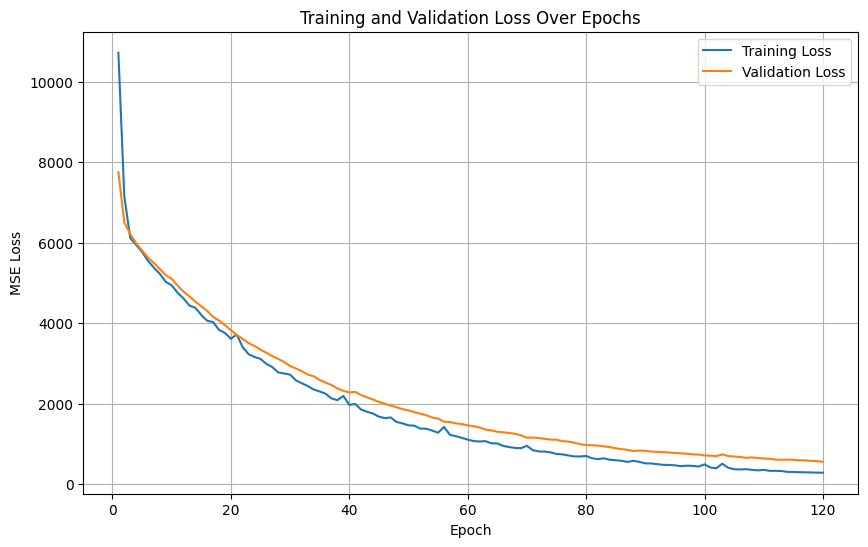

In [54]:
# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')#, marker='o')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')#, marker='x')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [ ]:
'''
# Save the model's state dictionary and metadata
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'val_loss': val_losses
}, './Models/lin_reg_checkpoint.pth')

# Save just the state dictionary for evaluation
torch.save(model.state_dict(), './Models/lin_reg.pth')
'''